In [8]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import arviz as az

In [9]:
SEEDS = 1000
Z_MAX = 5

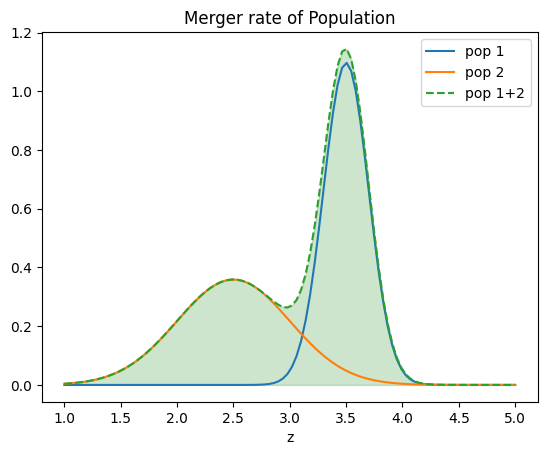

In [10]:
A = .55
MU_A = 3.5
MU_B = 2.5
SIGMA_A = .2
SIGMA_B = .5

merger_rate_A = lambda z : A * st.norm.pdf(x=z, loc=MU_A, scale=SIGMA_A)
merger_rate_B = lambda z : (1 - A) * st.norm.pdf(x=z, loc=MU_B, scale=SIGMA_B)
total_merger_rate = lambda z : merger_rate_A(z) + merger_rate_B(z)

# TESTING DISTRIBUTIONS

z = np.linspace(1, Z_MAX, 100)
plt.plot(z, merger_rate_A(z), label='pop 1')
plt.plot(z, merger_rate_B(z), label='pop 2')
plt.plot(z, total_merger_rate(z), label='pop 1+2', linestyle='--')
plt.fill_between(z,total_merger_rate(z), color='green', alpha=.2)
plt.legend()
plt.xlabel('z')
plt.title('Merger rate of Population')
del z

Text(0, 0.5, '$d^2N^s_\\uparrow/dzdt$')

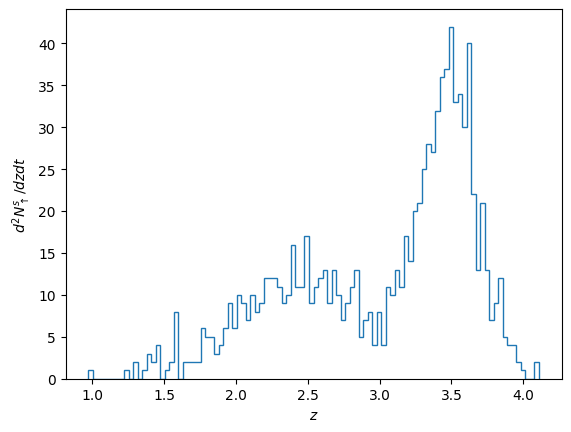

In [11]:
# DISTRIBUTION FOR SOURCE DETECTION

z_events = np.random.choice(np.linspace(0, Z_MAX, SEEDS), size=SEEDS, p=total_merger_rate(np.linspace(0, Z_MAX, SEEDS)) / np.sum(total_merger_rate(np.linspace(0, Z_MAX, SEEDS))))
# check the plot with the true distribution
plt.hist(z_events, bins=100, fill=False, histtype='step')
plt.xlabel('$z$')
plt.ylabel('$d^2N^s_\\uparrow/dzdt$')

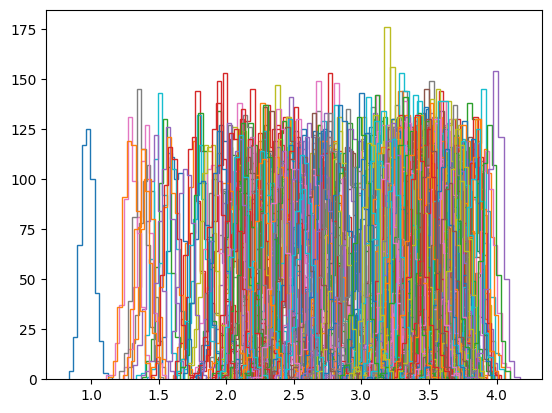

In [12]:
# DEFINING THE POSTERIORS ON Z

LEN_DATA = 500
Z_SRC = np.empty((SEEDS, LEN_DATA))
for i in range(SEEDS):
    Z_SRC[i] = st.norm(loc=z_events[i], scale=0.05).rvs(size=LEN_DATA)

# PLOTTING ALL THE EVENTS' Z

for i in range(SEEDS//2):
    plt.hist(Z_SRC[i], fill=False, histtype='step', label=i)

In [13]:
import pymc3 as pm

In [14]:
with pm.Model() as model:
    
    frac_A = pm.Uniform('A', lower=A-.1, upper=A+.1)
    frac_B = pm.Uniform('B', lower=(1-A)-.1, upper=(1-A)+.1)

    mu_A = pm.Uniform('MU_A', lower=MU_A-1, upper=MU_A+1)
    sigma_A = pm.Uniform('SIGMA_A', lower=SIGMA_A-1, upper=SIGMA_A+1)
    mu_B = pm.Uniform('MU_B', lower=MU_B-1, upper=MU_B+1)
    sigma_B = pm.Uniform('SIGMA_B', lower=SIGMA_B-1, upper=SIGMA_B+1)

    prior = frac_A * pm.Normal('mu_A', mu=mu_A, sigma=sigma_A) + frac_B * pm.Normal('mu_B', mu=mu_B, sigma=sigma_B)
    #prior = frac_A * pm.Normal('mu_A', mu=mu_A, sigma=sigma_A)
    
    obs = pm.Normal('obs', mu=prior, sigma=0.05, observed=Z_SRC)  # likelihood draws data points from prior
 
    # sample with 3 independent Markov chains
    
    #trace_METROPOLIS = pm.sample(draws=500, chains=2, step=pm.Metropolis(), return_inferencedata=True, cores=4)
    trace_NUTS = pm.sample(draws=500, chains=2, step=pm.NUTS(), return_inferencedata=True, cores=4)

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu_B, mu_A, SIGMA_B, MU_B, SIGMA_A, MU_A, B, A]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 824 seconds.
There were 143 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 219 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.566675457711877, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [15]:
#az.summary(trace_METROPOLIS, var_names=["A", "B", "MU_A", "MU_B", "SIGMA_A", "SIGMA_B"])
az.summary(trace_NUTS, var_names=["A", "B", "MU_A", "MU_B", "SIGMA_A", "SIGMA_B"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A,0.577,0.044,0.492,0.612,0.025,0.020,4.0,13.0,2.08
B,0.380,0.019,0.353,0.399,0.013,0.011,3.0,50.0,1.84
MU_A,3.300,0.555,2.831,4.221,0.346,0.279,3.0,59.0,1.86
MU_B,2.139,0.534,1.723,3.265,0.307,0.242,3.0,11.0,2.09
SIGMA_A,0.660,0.306,0.104,0.925,0.207,0.176,2.0,11.0,2.91
SIGMA_B,0.560,0.326,0.006,1.288,0.122,0.093,9.0,23.0,2.18


array([[<Axes: title={'center': 'A'}>, <Axes: title={'center': 'A'}>],
       [<Axes: title={'center': 'B'}>, <Axes: title={'center': 'B'}>],
       [<Axes: title={'center': 'MU_A'}>,
        <Axes: title={'center': 'MU_A'}>],
       [<Axes: title={'center': 'MU_B'}>,
        <Axes: title={'center': 'MU_B'}>],
       [<Axes: title={'center': 'SIGMA_A'}>,
        <Axes: title={'center': 'SIGMA_A'}>],
       [<Axes: title={'center': 'SIGMA_B'}>,
        <Axes: title={'center': 'SIGMA_B'}>]], dtype=object)

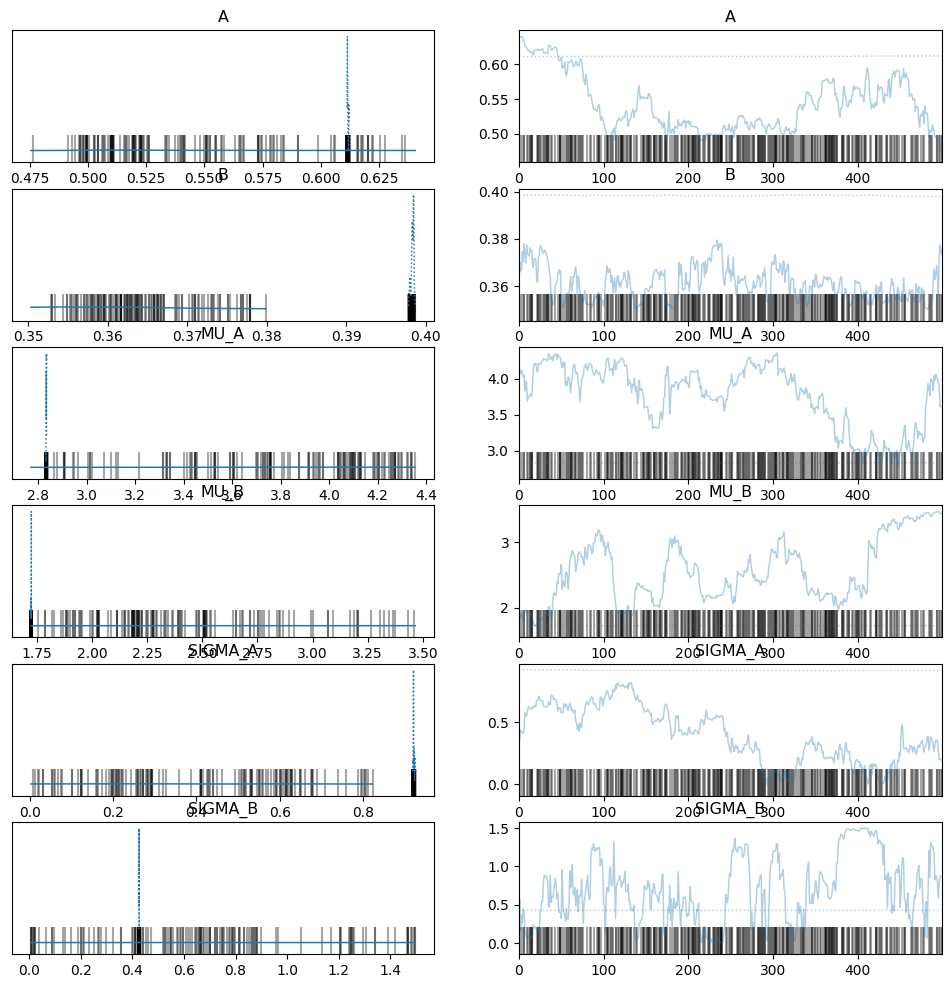

In [16]:
#az.plot_trace(trace_METROPOLIS, var_names=("A", "B", "MU_A", "MU_B", "SIGMA_A", "SIGMA_B"))
az.plot_trace(trace_NUTS, var_names=("A", "B", "MU_A", "MU_B", "SIGMA_A", "SIGMA_B"))

Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours


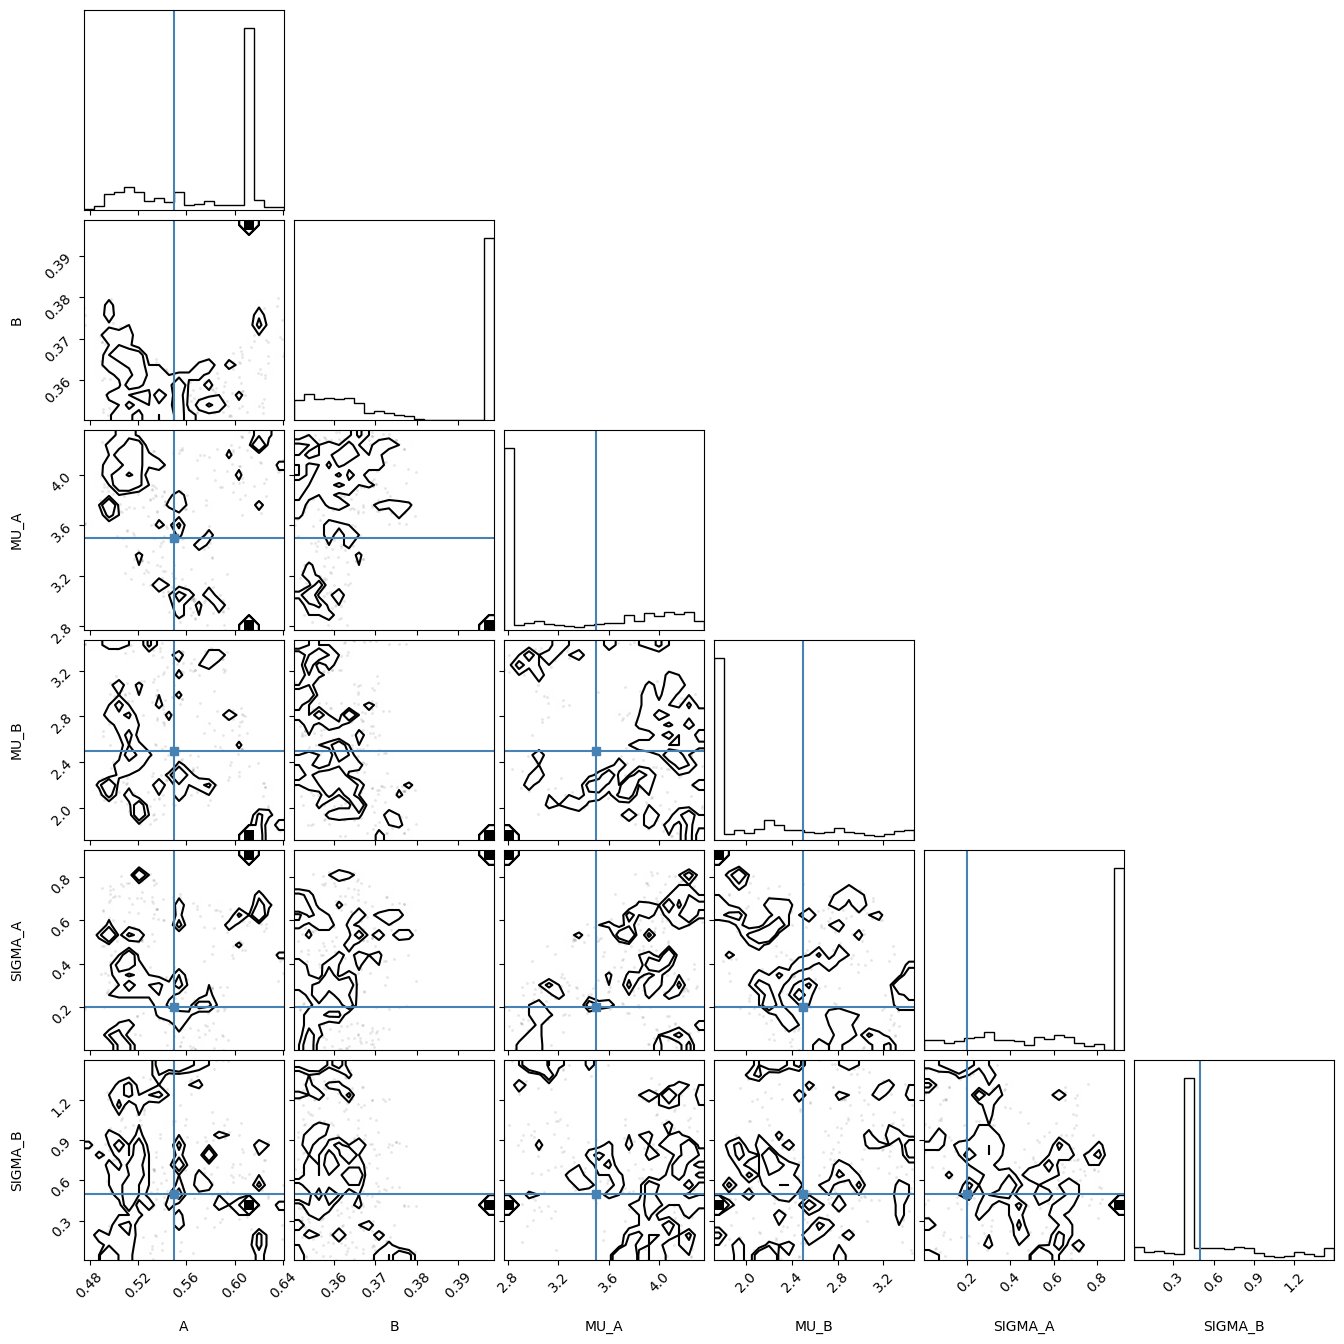

In [17]:
import corner
_ = corner.corner(trace_NUTS, var_names=["A", "B", "MU_A", "MU_B", "SIGMA_A", "SIGMA_B"], 
                  truths=dict(A=A, B=1-A, MU_A=MU_A, MU_B=MU_B, SIGMA_A=SIGMA_A, SIGMA_B=SIGMA_B))
#_ = corner.corner(trace_NUTS, var_names=["A", "B", "MU_A", "MU_B", "SIGMA_A", "SIGMA_B"])